# - 제목 : 합성곱 장단기기억 신경망을 이용한 웨이퍼 평탄화 공정의 MRR 예측 및 주요공정변수 선정

### - 연구 기여 : 1)특징공학에 자유로운 모델, 2)딥러닝 기반 MRR 예측 모델해석을 통한 공정변수 중요도 정량화, 3) 중요도 정량화 기반 주요공정변수 선정방법 제안

### - 포커싱 : 모델 사용이유 및 성능결과에 대한 해석

# 필수 라이브러리

In [ ]:
from tensorflow.keras.layers import Conv2D, LSTM, Flatten, Dense, Reshape
from tensorflow.keras.optimizers import Adam
import scipy as sp
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from sklearn.model_selection import train_test_split, KFold

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from sklearn.metrics import r2_score, mean_squared_error

import os
os.chdir('/content/drive/MyDrive/빅데이터분석연구실/연구작업')

from keras.utils.vis_utils import plot_model
import tensorflow as tf
import keras
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.models import load_model

In [ ]:
!pip install keras_tuner
import keras_tuner as kt

# 하이퍼파라미튜 최적화 - 케라스튜너

## 하이퍼밴드 - A_high

In [ ]:
INPUT_SHAPE = (100, 18, 1)
EPOCHS = 10
BATCH_SIZE = 32
ES_Patience = 10

es = EarlyStopping(
	monitor="val_loss",
	patience=ES_Patience,
	restore_best_weights=True)

Reduce_LR = ReduceLROnPlateau(
    monitor='val_loss', patience=5, factor=0.9, min_lr=0.00001)

In [ ]:
# 조정 대상 파라미터 : 은닉계층 수, 유닛 수, 학습률
def build_model(hp):
  model = keras.Sequential()
  for i in range(hp.Int('Num_layers', 2, 4)):
    Filters = hp.Choice('Conv_f'+str(i), values=[32, 64])
    model.add(Conv2D(filters=Filters,
                    kernel_size=(5,1), activation='relu', padding='same', name='Conv_'+str(i+1)))
  model.add(Reshape((100, 18*Filters), name='Reshape'))

  model.add(LSTM(units=hp.Int('LSTM_u1', min_value=64, max_value=256, step=64), return_sequences=True, name='LSTM_1'))
  model.add(LSTM(units=hp.Int('LSTM_u2', min_value=64, max_value=256, step=64), return_sequences=True, name='LSTM_2'))
  model.add(Flatten(name='Flatten'))

  model.add(Dense(1, activation='linear', name='Output'))

  hp_lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(
      optimizer = Adam(learning_rate=hp_lr),
      loss='mse'
  )
  return model

In [ ]:
HB_tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=10,
    hyperband_iterations=5,
    factor=3,
    seed=42,
    directory='HB_tuner_dir',
    project_name='HB_tuner_demo',
    overwrite=True)

HB_tuner.search(scaled_X_tr_A_high, y_tr_A_high, epochs=10,
             validation_data=(scaled_X_te_A_high, y_te_A_high), batch_size=BATCH_SIZE)

Trial 39 Complete [00h 00m 08s]
val_loss: 17540.083984375

Best val_loss So Far: 13.893065452575684
Total elapsed time: 00h 07m 07s

Search: Running Trial #40

Value             |Best Value So Far |Hyperparameter
3                 |3                 |Num_layers
32                |32                |Conv_f0
64                |32                |Conv_f1
64                |128               |LSTM_u1
192               |192               |LSTM_u2
0.01              |0.0001            |learning_rate
64                |64                |Conv_f2
64                |32                |Conv_f3
2                 |10                |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |0                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2


KeyboardInterrupt: ignored

## 베이지안최적화 - A_low

In [ ]:
INPUT_SHAPE = (100, 18, 1)
EPOCHS = 1000
BATCH_SIZE = 64
ES_Patience = 25

es = EarlyStopping(
	monitor="val_loss",
	patience=ES_Patience,
	restore_best_weights=True)

Reduce_LR = ReduceLROnPlateau(
    monitor='val_loss', patience=10, factor=0.9, min_lr=0.00001)

In [ ]:
# 조정 대상 파라미터 : 은닉층 수, 유닛 수, 학습률, 학습률스케쥴링, 가중치초기화, 정규화, 적층할 계층 수
def build_model(hp):
  inputs = keras.Input(shape=INPUT_SHAPE)

  x = Conv2D(filters=hp.Int('Conv_f1', min_value=32, max_value=128, step=32),
   kernel_size=(5,1), activation='relu', padding='same', name='Conv_1')(inputs)

  x = Conv2D(filters=hp.Int('Conv_f2', min_value=32, max_value=128, step=32),
   kernel_size=(5,1), activation='relu', padding='same', name='Conv_2')(x)

  x = Conv2D(filters=hp.Int('Conv_f3', min_value=32, max_value=128, step=32),
   kernel_size=(5,1), activation='relu', padding='same', name='Conv_3')(x)

  x = Conv2D(filters=hp.Int('Conv_f4', min_value=32, max_value=128, step=32),
   kernel_size=(5,1), activation='relu', padding='same', name='Conv_4')(x)

  x = Reshape((int(x.shape[1]), int(x.shape[2])*int(x.shape[3])), name='Reshape')(x)

  x = LSTM(units=hp.Int('LSTM_u1', min_value=64, max_value=256, step=64),
           return_sequences=True, name='LSTM_1')(x)
  x = LSTM(units=hp.Int('LSTM_u2', min_value=64, max_value=256, step=64),
           return_sequences=True, name='LSTM_2')(x)

  x = Flatten(name='Flatten')(x)

  outputs = keras.layers.Dense(1, activation='linear', name='Output')(x)
  model = keras.Model(inputs, outputs)

  hp_lr = hp.Choice('learning_rate', values=[1e-2, 5e-3, 1e-3, 5e-4, 1e-4])
  model.compile(
      optimizer = Adam(learning_rate=hp_lr),
      loss='mse'
  )
  return model

In [ ]:
BO_tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=10,
    seed=42,
    directory='BO_tuner_dir',
    project_name='BO_tuner_demo',
    overwrite=True)

BO_tuner.search(scaled_X_tr_A_low, y_tr_A_low, epochs=EPOCHS,
             validation_data=(scaled_X_te_A_low, y_te_A_low), batch_size=BATCH_SIZE, callbacks=[es, Reduce_LR])

Trial 7 Complete [00h 10m 28s]
val_loss: 13.748658180236816

Best val_loss So Far: 12.812029838562012
Total elapsed time: 00h 39m 51s

Search: Running Trial #8

Value             |Best Value So Far |Hyperparameter
32                |128               |Conv_f1
128               |96                |Conv_f2
128               |128               |Conv_f3
32                |32                |Conv_f4
64                |256               |LSTM_u1
256               |64                |LSTM_u2
0.0001            |0.0001            |learning_rate

Epoch 1/1000
13/13 [==============================] - 7s 222ms/step - loss: 5358.5327 - val_loss: 5145.7583 - lr: 1.0000e-04
Epoch 2/1000
13/13 [==============================] - 2s 127ms/step - loss: 4865.7905 - val_loss: 3360.4333 - lr: 1.0000e-04
Epoch 3/1000
13/13 [==============================] - 2s 131ms/step - loss: 1720.6831 - val_loss: 187.4126 - lr: 1.0000e-04
Epoch 4/1000
13/13 [==============================] - 2s 127ms/step - loss: 106.650

KeyboardInterrupt: ignored

In [ ]:
best_hps = BO_tuner.get_best_hyperparameters(num_trials = 1)[0]

best_model = BO_tuner.hypermodel.build(best_hps)

print(f"""
The hyperparameter search is complete. the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

best_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 18, 1)]      0         
                                                                 
 Conv_1 (Conv2D)             (None, 100, 18, 96)       576       
                                                                 
 Conv_2 (Conv2D)             (None, 100, 18, 32)       15392     
                                                                 
 Reshape (Reshape)           (None, 100, 576)          0         
                                                                 
 LSTM_1 (LSTM)               (None, 100, 128)          360960    
                                                                 
 Flatten (Flatten)           (None, 12800)             0         
                                                                 
 Output (Dense)              (None, 1)                 1280

In [ ]:
best_model.fit(scaled_X_tr_A_low, y_tr_A_low, epochs=1000, validation_data=(scaled_X_te_A_low, y_te_A_low), callbacks=[es, Reduce_LR])

Epoch 1/1000
25/25 [==============================] - 2s 33ms/step - loss: 835.3851 - val_loss: 153.4144 - lr: 0.0100
Epoch 2/1000
25/25 [==============================] - 0s 15ms/step - loss: 72.6897 - val_loss: 64.1006 - lr: 0.0100
Epoch 3/1000
25/25 [==============================] - 0s 15ms/step - loss: 44.8596 - val_loss: 39.7055 - lr: 0.0100
Epoch 4/1000
25/25 [==============================] - 0s 15ms/step - loss: 45.8671 - val_loss: 43.1516 - lr: 0.0100
Epoch 5/1000
25/25 [==============================] - 0s 14ms/step - loss: 42.7810 - val_loss: 43.2813 - lr: 0.0100
Epoch 6/1000
25/25 [==============================] - 0s 14ms/step - loss: 42.2627 - val_loss: 36.5273 - lr: 0.0100
Epoch 7/1000
25/25 [==============================] - 0s 14ms/step - loss: 39.6636 - val_loss: 48.7781 - lr: 0.0100
Epoch 8/1000
25/25 [==============================] - 0s 14ms/step - loss: 37.3131 - val_loss: 36.4233 - lr: 0.0100
Epoch 9/1000
25/25 [==============================] - 0s 15ms/step - l

# 1. CMP 데이터 불러오기

In [ ]:
# CMP 시계열 센서 및 MRR 선정
Sensors=['USAGE_OF_BACKING_FILM', 'USAGE_OF_DRESSER', 'USAGE_OF_DRESSER_TABLE', 'USAGE_OF_POLISHING_TABLE',  'USAGE_OF_MEMBRANE', 'USAGE_OF_PRESSURIZED_SHEET', 
         'MAIN_OUTER_AIR_BAG_PRESSURE', 'PRESSURIZED_CHAMBER_PRESSURE', 'CENTER_AIR_BAG_PRESSURE', 'RIPPLE_AIR_BAG_PRESSURE', 'EDGE_AIR_BAG_PRESSURE', 'RETAINER_RING_PRESSURE',
        'SLURRY_FLOW_LINE_A', 'SLURRY_FLOW_LINE_B', 'SLURRY_FLOW_LINE_C',
        'WAFER_ROTATION', 'STAGE_ROTATION', 'HEAD_ROTATION']

# MS1 = A_low, B / MS2 = A_high
Main_Sensors_1 = ['USAGE_OF_BACKING_FILM', 'USAGE_OF_DRESSER_TABLE', 'USAGE_OF_PRESSURIZED_SHEET', 'RETAINER_RING_PRESSURE']
Main_Sensors_2 = ['USAGE_OF_BACKING_FILM', 'USAGE_OF_DRESSER_TABLE', 'USAGE_OF_PRESSURIZED_SHEET']

MRR = ['WAFER_ID','AVG_REMOVAL_RATE']

# 그룹별 데이터셋 불러오기
A_low_tr = pd.read_csv('./dataset/A_low_tr.csv')
A_low_te = pd.read_csv('./dataset/A_low_te.csv')
A_low_va = pd.read_csv('./dataset/A_low_va.csv')

A_high_tr = pd.read_csv('./dataset/A_high_tr.csv')
A_high_te = pd.read_csv('./dataset/A_high_te.csv')
A_high_va = pd.read_csv('./dataset/A_high_va.csv')

B_tr = pd.read_csv('./dataset/B_tr.csv')
B_te = pd.read_csv('./dataset/B_te.csv')
B_va = pd.read_csv('./dataset/B_va.csv')


# 챔버와 시간 순으로 정렬하여 인덱스 설정
B_te.sort_values(['CHAMBER', 'TIMESTAMP'], inplace=True)
B_te.reset_index(inplace=True, drop=True)
B_tr.sort_values(['CHAMBER', 'TIMESTAMP'], inplace=True)
B_tr.reset_index(inplace=True, drop=True)
B_va.sort_values(['CHAMBER', 'TIMESTAMP'], inplace=True)
B_va.reset_index(inplace=True, drop=True)

A_low_te.sort_values(['CHAMBER', 'TIMESTAMP'], inplace=True)
A_low_te.reset_index(inplace=True, drop=True)
A_low_tr.sort_values(['CHAMBER', 'TIMESTAMP'], inplace=True)
A_low_tr.reset_index(inplace=True, drop=True)
A_low_va.sort_values(['CHAMBER', 'TIMESTAMP'], inplace=True)
A_low_va.reset_index(inplace=True, drop=True)

A_high_te.sort_values(['CHAMBER', 'TIMESTAMP'], inplace=True)
A_high_te.reset_index(inplace=True, drop=True)
A_high_tr.sort_values(['CHAMBER', 'TIMESTAMP'], inplace=True)
A_high_tr.reset_index(inplace=True, drop=True)
A_high_va.sort_values(['CHAMBER', 'TIMESTAMP'], inplace=True)
A_high_va.reset_index(inplace=True, drop=True)

# 2. 분석용데이터 생성

In [ ]:
# 함수1 : 웨이퍼 별 2차원 샘플 데이터를 추출함(웨이퍼, 공정시간, 센서) = (배치, 시간, 변수)
def split_by_wafer(data, Sensors):
  Wafer_IDs = data['WAFER_ID'].unique()
  Wafers = []

  for Wafer_ID in Wafer_IDs:
    Wafers.append(np.array(data[data['WAFER_ID'] == Wafer_ID][Sensors]))
  # print(len(Wafers))

  return Wafers


# 함수2 : 웨이퍼 별로 공정시간이 다르므로 쉐이프를 리사이징함(다운 샘플링, 시간 길이 100으로 고정)
def resize_by_wafer(data_by_wafer, Sensors):
  resized_Wafers = []

  for Wafer_idx in range(len(data_by_wafer)):
    resized_Wafers.append(cv2.resize(data_by_wafer[Wafer_idx], (len(Sensors), 100), interpolation=cv2.INTER_NEAREST))
  # print(len(resized_Wafers))

  return np.array(resized_Wafers)


# 함수3 : 입력 데이터 최소최대 정규화
def scaling(X_tr, X_te):
  scaled_X_tr = scaler.fit_transform(X_tr.reshape(-1,1))
  scaled_X_tr = scaled_X_tr.reshape(X_tr.shape[0], X_tr.shape[1], X_tr.shape[2], 1)

  scaled_X_te = scaler.fit_transform(X_te.reshape(-1,1))
  scaled_X_te = scaled_X_te.reshape(X_te.shape[0], X_te.shape[1], X_te.shape[2], 1)
  
  print(scaled_X_tr.shape, scaled_X_te.shape)

  return scaled_X_tr, scaled_X_te

In [ ]:
# A_low 최종 데이터셋(X_tr_A_low, y_tr_A_low)
A_low_tr_by_wafer = split_by_wafer(A_low_tr, Sensors)
A_low_te_by_wafer = split_by_wafer(A_low_te, Sensors)

A_low_tr_resized = resize_by_wafer(A_low_tr_by_wafer, Sensors)
A_low_te_resized = resize_by_wafer(A_low_te_by_wafer, Sensors)

X_tr_A_low = A_low_tr_resized
X_te_A_low = A_low_te_resized

y_tr_A_low = np.array(A_low_tr[MRR].groupby(by='WAFER_ID', sort=False).mean())
y_te_A_low = np.array(A_low_te[MRR].groupby(by='WAFER_ID', sort=False).mean())


# A_high 최종 데이터셋(X_tr_A_high, y_tr_A_high)
A_high_tr_by_wafer = split_by_wafer(A_high_tr, Sensors)
A_high_te_by_wafer = split_by_wafer(A_high_te, Sensors)

A_high_tr_resized = resize_by_wafer(A_high_tr_by_wafer, Sensors)
A_high_te_resized = resize_by_wafer(A_high_te_by_wafer, Sensors)

X_tr_A_high = A_high_tr_resized
X_te_A_high = A_high_te_resized

y_tr_A_high = np.array(A_high_tr[MRR].groupby(by='WAFER_ID', sort=False).mean())
y_te_A_high = np.array(A_high_te[MRR].groupby(by='WAFER_ID', sort=False).mean())


# B 최종 데이터셋(X_tr_B, y_tr_B)
B_tr_by_wafer = split_by_wafer(B_tr, Sensors)
B_te_by_wafer = split_by_wafer(B_te, Sensors)

B_tr_resized = resize_by_wafer(B_tr_by_wafer, Sensors)
B_te_resized = resize_by_wafer(B_te_by_wafer, Sensors)

X_tr_B=B_tr_resized
X_te_B=B_te_resized

y_tr_B = np.array(B_tr[MRR].groupby(by='WAFER_ID', sort=False).mean())
y_te_B = np.array(B_te[MRR].groupby(by='WAFER_ID', sort=False).mean())


# 딥러닝 모델 인풋에 적합한 스케일링
scaled_X_tr_A_low, scaled_X_te_A_low = scaling(X_tr_A_low, X_te_A_low)
scaled_X_tr_A_high, scaled_X_te_A_high = scaling(X_tr_A_high, X_te_A_high)
scaled_X_tr_B, scaled_X_te_B = scaling(X_tr_B, X_te_B)

(798, 100, 18, 1) (165, 100, 18, 1)
(364, 100, 18, 1) (73, 100, 18, 1)
(815, 100, 18, 1) (186, 100, 18, 1)


In [ ]:
# 최종 인풋 데이터 저장
data = [scaled_X_tr_A_low, scaled_X_tr_A_high, scaled_X_tr_B, scaled_X_te_A_low, scaled_X_te_A_high, scaled_X_te_B,
        y_tr_A_low, y_tr_A_high, y_tr_B, y_te_A_low, y_te_A_high, y_te_B]

for i,n in enumerate(data):
  np.save('./Final_input/{}'.format(i+1), n)

# 3. Conv-LSTM 딥러닝 회귀모형 구축

In [ ]:
# LSTM 레이어가 학습률에 따라 수렴 방향 민감
# 커널사이즈 5x1이 LSTM과 잘 맞는 것 같음. 식이나 그림으로 표현할 수 있는지?
def DeepConvLSTM(model_input):
  x = keras.layers.Conv2D(filters=64, kernel_size=(5,1), activation='relu', padding='same', name='Conv_1')(model_input)
  x = keras.layers.Conv2D(filters=64, kernel_size=(5,1), activation='relu', padding='same', name='Conv_2')(x)
  x = keras.layers.Conv2D(filters=64, kernel_size=(5,1), activation='relu', padding='same', name='Conv_3')(x)
  x = keras.layers.Conv2D(filters=64, kernel_size=(5,1), activation='relu', padding='same', name='Conv_4')(x)

  x = keras.layers.Reshape((int(x.shape[1]), int(x.shape[2])*int(x.shape[3])), name='Reshape')(x)
  x = keras.layers.LSTM(128, return_sequences=True, name='LSTM_1')(x)
  x = keras.layers.LSTM(128, return_sequences=True, name='LSTM_2')(x)
  x = keras.layers.Flatten(name='Flatten')(x)

  Output = keras.layers.Dense(1, activation='linear', name='Output')(x)
  model = keras.Model(model_input, Output, name='DeepConvLSTM')

  return model


def DeepConvLSTM2(model_input):
  x = keras.layers.Conv2D(filters=64, kernel_size=(5,1), activation='relu', padding='same', name='Conv_1')(model_input)
  x = keras.layers.Conv2D(filters=64, kernel_size=(5,1), activation='relu', padding='same', name='Conv_2')(x)
  x = keras.layers.Conv2D(filters=64, kernel_size=(5,1), activation='relu', padding='same', name='Conv_3')(x)
  x = keras.layers.Conv2D(filters=64, kernel_size=(5,1), activation='relu', padding='same', name='Conv_4')(x)

  x = keras.layers.Permute((2,1,3), name='Permute')(x)
  x = keras.layers.Reshape((int(x.shape[1]), int(x.shape[2])*int(x.shape[3])), name='Reshape')(x)
  x = keras.layers.LSTM(128, return_sequences=True, name='LSTM_1')(x)
  x = keras.layers.LSTM(128, return_sequences=True, name='LSTM_2')(x)
  x = keras.layers.Flatten(name='Flatten')(x)

  Output = keras.layers.Dense(1, activation='linear',  name='Output')(x)
  model = keras.Model(model_input, Output, name='DeepConvLSTM2')

  return model


def Baseline_CNN(model_input):
  x = keras.layers.Conv2D(filters=64, kernel_size=(5,1), activation='relu', padding='same', name='Conv_1')(model_input)
  x = keras.layers.Conv2D(filters=64, kernel_size=(5,1), activation='relu', padding='same', name='Conv_2')(x)
  x = keras.layers.Conv2D(filters=64, kernel_size=(5,1), activation='relu', padding='same', name='Conv_3')(x)
  x = keras.layers.Conv2D(filters=64, kernel_size=(5,1), activation='relu', padding='same', name='Conv_4')(x)

  x = keras.layers.Flatten()(x)
  x = keras.layers.Dense(128, activation='relu')(x)
  x = keras.layers.Dense(128, activation='relu')(x)

  Output = keras.layers.Dense(1, activation='linear', name='Output')(x)
  model = keras.Model(model_input, Output, name='Baseline_CNN')

  return model


def compile_and_train(X_tr, y_tr, X_te, y_te, model, num_epochs, data_name, batch_size): 
    Adam=tf.keras.optimizers.Adam(0.0001)
    model.compile(loss='mean_squared_error', optimizer=Adam)
    Filepath = 'save_model/{}_{}_epoch{}_batch{}.h5'.format(model.name, data_name, num_epochs, batch_size)
    Checkpoint = ModelCheckpoint(Filepath, monitor='val_loss', save_best_only=True)
    ReduceLR = ReduceLROnPlateau(monitor='val_loss', patience=25, factor=0.9, min_lr=0.00001)
    EarlyStop = EarlyStopping(monitor="val_loss", patience=100, verbose=2)
    
    history = model.fit(x=X_tr, y=y_tr, batch_size=batch_size, epochs=num_epochs, verbose=2,
                        callbacks=[Checkpoint, ReduceLR, EarlyStop], validation_data=(X_te, y_te), shuffle=True)
    return history

In [ ]:
# 데이터 그룹 별 예측 성능 검증
model_input = keras.layers.Input(shape=(100, len(Sensors), 1))

def k_fold_A_low(model, epochs, num):
  print('A_low training start')
  for i in range(num):
    _ = compile_and_train(scaled_X_tr_A_low, y_tr_A_low, scaled_X_te_A_low, y_te_A_low,
                          model(model_input), num_epochs=epochs, batch_size=64, data_name='A_low_{}'.format(i+1))

def k_fold_A_high(model, epochs, num):
  print('A_high training start')
  for i in range(num):
    _ = compile_and_train(scaled_X_tr_A_high, y_tr_A_high, scaled_X_te_A_high, y_te_A_high,
                          model(model_input), num_epochs=epochs, batch_size=32, data_name='A_high_{}'.format(i+1))

def k_fold_B(model, epochs, num):
  print('B training start')
  for i in range(num):
    _ = compile_and_train(scaled_X_tr_B, y_tr_B, scaled_X_te_B, y_te_B,
                          model(model_input), num_epochs=epochs, batch_size=64, data_name='B_{}'.format(i+1))

In [ ]:
k_fold_A_low(Baseline_CNN, 1000, 3)

k_fold_A_high(Baseline_CNN, 1000, 3)

k_fold_B(Baseline_CNN, 1000, 3)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
13/13 - 0s - loss: 11.6823 - val_loss: 19.0404 - lr: 1.0000e-04 - 414ms/epoch - 32ms/step
Epoch 459/1000
13/13 - 0s - loss: 11.4857 - val_loss: 19.0226 - lr: 1.0000e-04 - 450ms/epoch - 35ms/step
Epoch 460/1000
13/13 - 0s - loss: 12.3113 - val_loss: 20.4288 - lr: 1.0000e-04 - 467ms/epoch - 36ms/step
Epoch 461/1000
13/13 - 0s - loss: 12.9025 - val_loss: 20.9810 - lr: 1.0000e-04 - 462ms/epoch - 36ms/step
Epoch 462/1000
13/13 - 0s - loss: 12.5198 - val_loss: 20.9250 - lr: 1.0000e-04 - 463ms/epoch - 36ms/step
Epoch 463/1000
13/13 - 0s - loss: 12.4339 - val_loss: 21.9577 - lr: 1.0000e-04 - 452ms/epoch - 35ms/step
Epoch 464/1000
13/13 - 1s - loss: 12.3025 - val_loss: 18.9462 - lr: 1.0000e-04 - 1s/epoch - 82ms/step
Epoch 465/1000
13/13 - 0s - loss: 11.2256 - val_loss: 19.4243 - lr: 1.0000e-04 - 423ms/epoch - 33ms/step
Epoch 466/1000
13/13 - 0s - loss: 12.1563 - val_loss: 20.4895 - lr: 1.0000e-04 - 449ms/epoch - 35ms/step
Epoch 467/1000
13/13 - 0s - loss: 11.

In [ ]:
Model_A_high = load_model('/content/drive/MyDrive/빅데이터분석연구실/논문작업/save_model/MS_DeepConvLSTM_A_high_1_epoch1000_batch32.h5')
Model_A_high.evaluate(scaled_X_te_A_high, y_te_A_high)

3/3 [==============================] - 1s 10ms/step - loss: 7.9909


7.99090576171875

In [ ]:
# All Sensors_CNN
Model_A_low = load_model('/content/drive/MyDrive/빅데이터분석연구실/논문작업/save_model/Baseline_CNN_A_low_1_epoch1000_batch64.h5')
Model_A_low.evaluate(scaled_X_te_A_low, y_te_A_low)

Model_A_high = load_model('/content/drive/MyDrive/빅데이터분석연구실/논문작업/save_model/Baseline_CNN_A_high_3_epoch1000_batch32.h5')
Model_A_high.evaluate(scaled_X_te_A_high, y_te_A_high)

Model_B = load_model('/content/drive/MyDrive/빅데이터분석연구실/논문작업/save_model/Baseline_CNN_B_3_epoch1000_batch64.h5')
Model_B.evaluate(scaled_X_te_B, y_te_B)

6/6 [==============================] - 0s 7ms/step - loss: 14.0110


14.01102352142334

In [ ]:
k_fold_A_low(DeepConvLSTM, 2000, 3)

k_fold_A_high(DeepConvLSTM, 2000, 3)

k_fold_B(DeepConvLSTM, 2000, 3)

In [ ]:
# All Sensors
Model_A_low = load_model('/content/drive/MyDrive/빅데이터분석연구실/논문작업/save_model/final_model/DeepConvLSTM_A_low_1_epoch1000_batch64_mse7.h5')
Model_A_low.evaluate(scaled_X_te_A_low, y_te_A_low)

Model_A_high = load_model('/content/drive/MyDrive/빅데이터분석연구실/논문작업/save_model/final_model/DeepConvLSTM_A_high_2_epoch1000_batch32_mse8.h5')
Model_A_high.evaluate(scaled_X_te_A_high, y_te_A_high)

Model_B = load_model('/content/drive/MyDrive/빅데이터분석연구실/논문작업/save_model/final_model/DeepConvLSTM_B_1_epoch1000_batch64_mse13.h5')
Model_B.evaluate(scaled_X_te_B, y_te_B)

6/6 [==============================] - 1s 33ms/step - loss: 13.3430


13.342999458312988

In [ ]:
# Main Sensors2
Model_A_low = load_model('/content/drive/MyDrive/빅데이터분석연구실/논문작업/save_model/Main_Sensors/MS2_DeepConvLSTM_A_low_2_epoch1000_batch64_mse7.h5')
Model_A_low.evaluate(scaled_X_te_A_low, y_te_A_low)

Model_A_high = load_model('/content/drive/MyDrive/빅데이터분석연구실/논문작업/save_model/Main_Sensors/MS2_DeepConvLSTM_A_high_1_epoch2000_batch32_mse9.h5')
Model_A_high.evaluate(scaled_X_te_A_high, y_te_A_high)

Model_B = load_model('/content/drive/MyDrive/빅데이터분석연구실/논문작업/save_model/Main_Sensors/MS2_DeepConvLSTM_B_1_epoch2000_batch64_mse10.h5')
Model_B.evaluate(scaled_X_te_B, y_te_B)

# 성능 비교 및 시각화
- 기본모델과 메인센서모델의 RMSE, R^2, 시각화 등..

In [ ]:
print(mean_squared_error(y_te_A_low, Model_A_low.predict(scaled_X_te_A_low)), mean_squared_error(y_te_B, Model_B.predict(scaled_X_te_B)), mean_squared_error(y_te_A_high, Model_A_high.predict(scaled_X_te_A_high)))
print(r2_score(y_te_A_low, Model_A_low.predict(scaled_X_te_A_low)), r2_score(y_te_B, Model_B.predict(scaled_X_te_B)), r2_score(y_te_A_high, Model_A_high.predict(scaled_X_te_A_high)))

Total_True = np.concatenate((y_te_A_low, y_te_B, y_te_A_high))
Total_Pred = np.concatenate((Model_A_low.predict(scaled_X_te_A_low), Model_B.predict(scaled_X_te_B), Model_A_high.predict(scaled_X_te_A_high)))

r2_score(Total_True, Total_Pred)

8.57405833531506 13.343001240240513 8.56721533123215
0.7920112620362053 0.8166387755754825 0.4067647478388403


0.98779554164258

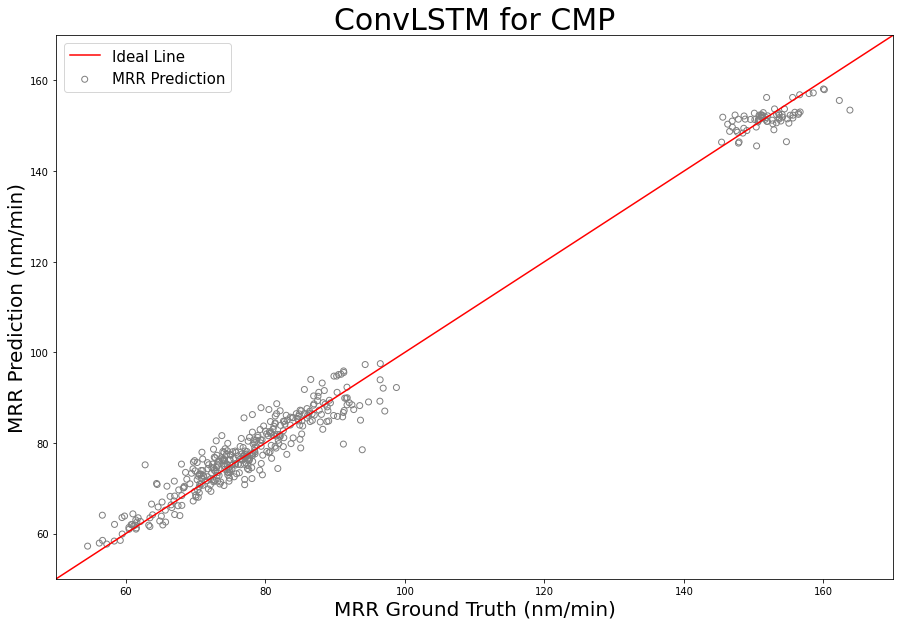

In [ ]:
plt.figure(figsize=(15,10))
plt.title('ConvLSTM for CMP', fontsize=30)
plt.rc('font', size=15)
plt.rc('legend', fontsize=15)

plt.scatter(Total_True, Total_Pred, marker='o', facecolors='none', edgecolors='grey', label='MRR Prediction')
x = [a for a in range(50,175)]
plt.xlabel('MRR Ground Truth (nm/min)', fontsize=20)
plt.ylabel('MRR Prediction (nm/min)', fontsize=20)

plt.xlim((50,170))
plt.ylim((50,170))
plt.plot(x,x,'r',label='Ideal Line')

plt.legend()

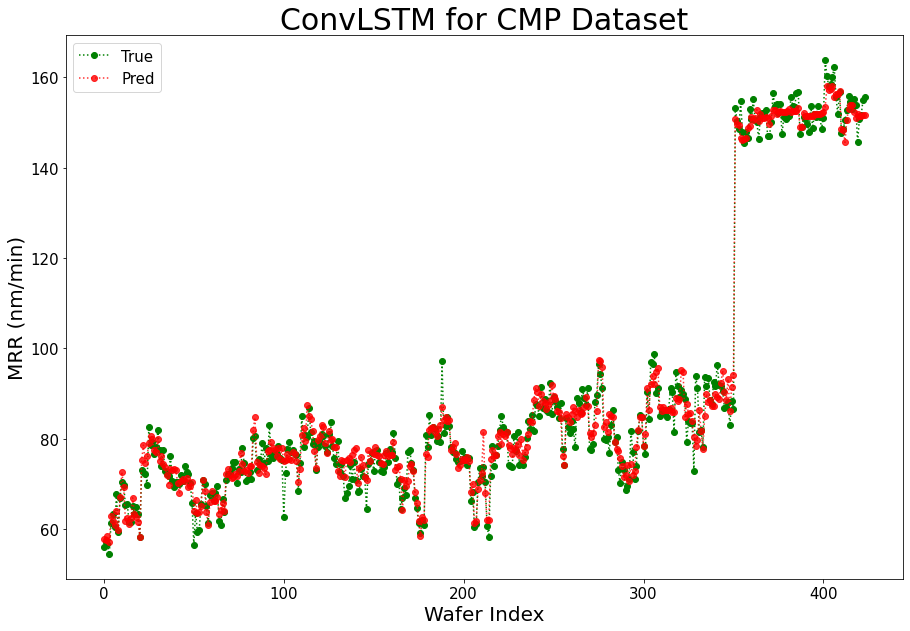

In [ ]:
plt.figure(figsize=(15,10))
plt.title('ConvLSTM for CMP Dataset', fontsize=30)
plt.plot(np.array(Total_True),'g', label='True', marker='o', linestyle=':')
plt.plot(np.array(Total_Pred),'r', label='Pred', marker='o', linestyle=':', alpha=0.8)

plt.xlabel('Wafer Index', fontsize=20)
plt.ylabel('MRR (nm/min)', fontsize=20)
plt.legend()
plt.rc('legend', fontsize=15)